###### Imports

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag.stanford import StanfordNERTagger
from sklearn.feature_extraction import text
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import wordnet
import json

###### Variables

In [2]:
got_url = '../data/got.csv'
hp_url = '../data/hp.csv'

got_characters = ['jon','tyrion','cersei','daenerys']
hp_characters = ['harry','hermione','ron']

top_words = 50
common_words_file = './common_words/20k.txt'
output_file = './trigger_words.json'
characters = got_characters + hp_characters

### Load Data driver functions

#### load_###(url_to_file, characters[])
Line Format: 
Index;Season;Episode;Sentence;Name;N_serie;N_Season;Emision Date

Output: 
[{character_name: [all_chats]]

In [3]:
def load_got(url_to_file, characters):
    got_df = pd.read_csv(url_to_file, delimiter=';')
    got_data = {}
    for c in characters:
        got_data[c] = [' '.join(list(got_df[got_df['Name'] == c].Sentence))]
    got_data = pd.DataFrame.from_dict(got_data).transpose()
    got_data.columns = ['data']
    got_data = got_data.sort_index()
    return got_data

In [4]:
def load_hp(url_to_file, characters):
    hp_df = pd.read_csv(hp_url, delimiter=';')
    hp_data = {}
    for c in characters:
        hp_data[c] = [' '.join(list(hp_df[hp_df['Character'].str.lower() == c].Sentence))]
    hp_data = pd.DataFrame.from_dict(hp_data).transpose()
    hp_data.columns = ['data']
    hp_data = hp_data.sort_index()
    return hp_data

In [5]:
combined = pd.concat([load_got(got_url, got_characters),load_hp(hp_url, hp_characters)])
combined

,data
cersei,And you never worry about anything When we wer...
daenerys,We’ve been his guests for over a year and he’s...
jon,Go on Father’s watching And your mother Don’t ...
tyrion,Mmh It is true what they say about the Norther...
harry,"Yes, Aunt Petunia. Yes, Uncle Vernon. He's asl..."
hermione,Has anyone seen a toad? A boy named Neville's ...
ron,Excuse me. Do you mind? Everywhere else is ful...


### Data cleaning

##### add Names, etc' to stop_words

In [6]:
st = StanfordNERTagger('ner/english.all.3class.distsim.crf.ser.gz','ner/stanford-ner.jar')

In [7]:
def extract_ner(text):
    stop_words_ner = []
    tokens = nltk.tokenize.word_tokenize(text)
    tags = st.tag(tokens)
    for tag in tags:
        if tag[1] in ["PERSON", "LOCATION", "ORGANIZATION"]:
            if tag[0] not in stop_words_ner:
                stop_words_ner.append(tag[0])
    return stop_words_ner

In [8]:
#applying ner on all data
stop_words_ner_all = []
[stop_words_ner_all.extend(l) for l in combined.data.apply(extract_ner)]
stop_words_ner_all

['Jon',
 'Arryn',
 'Robert',
 'Joffrey',
 'Sansa',
 'Shes',
 'Aerys',
 'Targaryen',
 'Hes',
 'Kingsroad',
 'Ned',
 'Stark',
 'Dothraki',
 'Lyanna',
 'Starks',
 'Jaime',
 'Baelor',
 'Ser',
 'Barristan',
 'Lady',
 'Catelyn',
 'Se',
 'Rise',
 'Council',
 'Lannister',
 'Kingsguard',
 'Careful',
 'Slynt',
 'Robb',
 'Arya',
 'Baelish',
 'Sigil',
 'Ive',
 'Janos',
 'Queen',
 'Regent',
 'Ha',
 'Dorne',
 'Baratheon',
 'Martells',
 'Shell',
 'Littlefinger',
 'Kingswood',
 'Targaryens',
 'Varys',
 'Mandon',
 'Joffreys',
 'Stannis',
 'Id',
 'Enjoy',
 'Lorath',
 'Westeros',
 'Lorathi',
 'Shae',
 'Small',
 'Casterly',
 'Rock',
 'Youre',
 'Tyrell',
 'Margaery',
 'Renly',
 'Wait',
 'Yes',
 'House',
 'Reyne',
 'Castamere',
 'Arent',
 'He',
 'Myrcella',
 'We',
 'Highgarden',
 'Selwyn',
 'Tarths',
 'Sworn',
 'Oberyn',
 'TYRION',
 'Joff',
 'Tommens',
 'Tommen',
 'Iron',
 'Bank',
 'Blackwater',
 'Bay',
 'Kings',
 'Landing',
 'Loras',
 'Tywin',
 'Prince',
 'Doran',
 'Uncle',
 'Kevan',
 'Good',
 'Im',
 'Hows

In [9]:
# all to lowercase
stop_words_ner_all_ = []
[stop_words_ner_all_.append(w.lower()) for w in stop_words_ner_all]
stop_words_ner_all_

['jon',
 'arryn',
 'robert',
 'joffrey',
 'sansa',
 'shes',
 'aerys',
 'targaryen',
 'hes',
 'kingsroad',
 'ned',
 'stark',
 'dothraki',
 'lyanna',
 'starks',
 'jaime',
 'baelor',
 'ser',
 'barristan',
 'lady',
 'catelyn',
 'se',
 'rise',
 'council',
 'lannister',
 'kingsguard',
 'careful',
 'slynt',
 'robb',
 'arya',
 'baelish',
 'sigil',
 'ive',
 'janos',
 'queen',
 'regent',
 'ha',
 'dorne',
 'baratheon',
 'martells',
 'shell',
 'littlefinger',
 'kingswood',
 'targaryens',
 'varys',
 'mandon',
 'joffreys',
 'stannis',
 'id',
 'enjoy',
 'lorath',
 'westeros',
 'lorathi',
 'shae',
 'small',
 'casterly',
 'rock',
 'youre',
 'tyrell',
 'margaery',
 'renly',
 'wait',
 'yes',
 'house',
 'reyne',
 'castamere',
 'arent',
 'he',
 'myrcella',
 'we',
 'highgarden',
 'selwyn',
 'tarths',
 'sworn',
 'oberyn',
 'tyrion',
 'joff',
 'tommens',
 'tommen',
 'iron',
 'bank',
 'blackwater',
 'bay',
 'kings',
 'landing',
 'loras',
 'tywin',
 'prince',
 'doran',
 'uncle',
 'kevan',
 'good',
 'im',
 'hows

In [10]:
# remove duplicates:
stop_words_ner_unique = []
for word in stop_words_ner_all_:
    if word not in stop_words_ner_unique:
        stop_words_ner_unique.append(word)

In [11]:
# Add to stop words
stop_words = text.ENGLISH_STOP_WORDS.union(stop_words_ner_unique)

##### Additional stop word - Cherrypick (#cherrypick)

In [12]:
additional_stop_words = ['just', 'right', 'hagrids', 'harrys', 'lumos', 
                         'theyre', 'youd', 'youll', 'theyll', 'dont', 'oh', 
                         'fortuna', 'mr', 'mrs', 'mummy', 'arania', 'li', 'tah'
                         'um', 'oonnn', 'riddikulus', 'bogeyflavoured', 'nimbus'
                         'na', 'havea']

In [13]:
stop_words = stop_words.union(additional_stop_words)

##### Regex Cleanup

In [14]:
def cleaner(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

In [15]:
data_clean_1 = pd.DataFrame(combined.data.apply(cleaner))



#### Additional Cleanup here:

stemming, bigrams, lemmination

###### trim words to get something more meaningful

ideas:
keep only: 
- adj: a word or phrase naming an attribute, added to or grammatically related to a noun to modify or describe it.
- verb: a word used to describe an action, state, or occurrence, and forming the main part of the predicate of a sentence, such as hear, become, happen
- adverbs: a word or phrase that modifies or qualifies an adjective, verb, or other adverb or a word group, expressing a relation of place, time, circumstance, manner, cause, degree, etc. (e.g., gently, quite, then, there ).


In [16]:
def clean_tags(text):
    token_arr = word_tokenize(text)
    text_tag = nltk.pos_tag(token_arr)
    filtered_text = ''
    for w in text_tag:
        if w[1] in tags:
            filtered_text += ' ' + w[0]
    return filtered_text

In [17]:
'''
    JJ - adjuctive
    RB - Adverb
'''
tags = ['JJ','JJR','JJS','RB','RBR','RBS']
data_clean_2 = pd.DataFrame(data_clean_1.data.apply(clean_tags))
data_clean_2

,data
cersei,never casterly never surely dead little beast...
daenerys,weve never i magister beautiful common only i...
jon,dont too much now lord stark not stark so pre...
tyrion,true northern other pretty closed odd sister ...
harry,yes petunia there ugly just ive never often b...
hermione,magic then sure real well not very good ive o...
ron,everywhere else full true i really also liver...


In [18]:
corpus = data_clean_2

#### Document Term Matrix

In [19]:
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(corpus.data)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = corpus.index
data_dtm

/Users/idanhahn/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eastwatch', 'know'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,able,aboveaverage,absolutely,abstract,abundantly,accidentally,accomplished,accountable,actively,actual,...,worth,wouldbe,wouldnt,wounded,wrong,yeah,yellow,young,younger,youngest
cersei,0,0,0,0,0,0,0,1,0,2,...,0,1,0,0,2,0,0,4,0,1
daenerys,2,0,0,0,0,0,0,0,0,1,...,1,0,0,0,4,0,0,3,0,0
jon,3,0,0,0,0,0,0,0,0,0,...,1,0,0,1,3,0,0,2,1,0
tyrion,6,1,1,2,1,0,1,0,1,2,...,3,0,1,1,15,0,0,6,1,2
harry,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,4,2,0,0,0,0
hermione,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
ron,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,2,0,0,1


In [20]:
data_t = data_dtm.transpose()
top_dict = {}
for c in data_t.columns:
    top = data_t[c].sort_values(ascending=False).head(top_words)
    top_dict[c] = list(zip(top.index, top.values))
top_dict

{'cersei': [('little', 38),
  ('away', 16),
  ('sure', 13),
  ('quite', 12),
  ('really', 11),
  ('best', 8),
  ('happy', 8),
  ('free', 7),
  ('true', 7),
  ('safe', 7),
  ('strong', 7),
  ('lovely', 6),
  ('beautiful', 6),
  ('soon', 6),
  ('open', 6),
  ('grand', 5),
  ('difficult', 5),
  ('eldest', 5),
  ('instead', 5),
  ('new', 5),
  ('royal', 4),
  ('powerful', 4),
  ('second', 4),
  ('possible', 4),
  ('poor', 4),
  ('young', 4),
  ('real', 4),
  ('clever', 4),
  ('alive', 4),
  ('past', 4),
  ('stupid', 4),
  ('didnt', 4),
  ('far', 4),
  ('wont', 3),
  ('necessary', 3),
  ('eventually', 3),
  ('certain', 3),
  ('sensitive', 3),
  ('sister', 3),
  ('dove', 3),
  ('possibly', 3),
  ('imagine', 3),
  ('actually', 3),
  ('stronger', 3),
  ('apart', 3),
  ('ago', 3),
  ('terrible', 3),
  ('formal', 2),
  ('lancel', 2),
  ('surely', 2)],
 'daenerys': [('far', 10),
  ('free', 10),
  ('away', 10),
  ('forward', 7),
  ('little', 6),
  ('best', 6),
  ('happy', 6),
  ('second', 6),
  ('

#### Visual

In [21]:
# take original dataframe (combined) and lowercasing data


In [22]:
wc = WordCloud(stopwords=stop_words, background_color='white', colormap='Dark2', max_font_size=150, random_state=42)

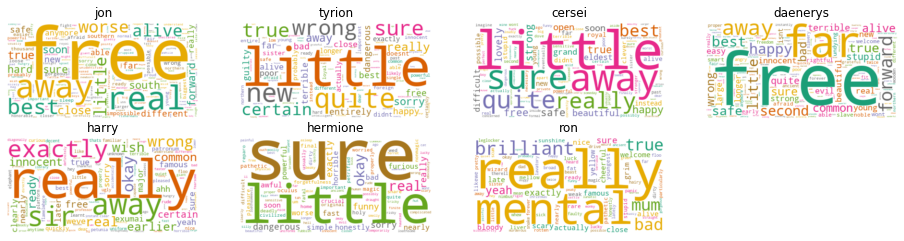

In [23]:
plt.rcParams['figure.figsize'] = [16, 6]

for index, c in enumerate(characters):
    wc.generate(corpus.data[c])
    plt.subplot(3,4, index+1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(c)

##### Additional round of cleaning (#Cherrypick)

In [24]:
# Look at the most common top words --> add them to the stop word list
from collections import Counter

# Let's first pull out the top 30 words for each comedian
words = []
for c in characters:
    top = [word for (word, count) in top_dict[c]]
    for t in top:
        words.append(t)
        
words

['free',
 'away',
 'real',
 'little',
 'alive',
 'worse',
 'best',
 'close',
 'true',
 'sure',
 'hard',
 'new',
 'forward',
 'far',
 'safe',
 'different',
 'soon',
 'south',
 'really',
 'southern',
 'anymore',
 'able',
 'wrong',
 'impossible',
 'loose',
 'easier',
 'important',
 'sleep',
 'thousand',
 'normal',
 'gorgeous',
 'possible',
 'larger',
 'powerful',
 'fair',
 'fight',
 'probably',
 'ready',
 'proud',
 'biggest',
 'afraid',
 'northern',
 'sorry',
 'closer',
 'come',
 'young',
 'honorable',
 'daily',
 'reckless',
 'late',
 'little',
 'quite',
 'new',
 'wrong',
 'sure',
 'true',
 'certain',
 'really',
 'away',
 'sorry',
 'best',
 'free',
 'guilty',
 'happy',
 'entirely',
 'bad',
 'far',
 'dangerous',
 'terrible',
 'longer',
 'poor',
 'alive',
 'actually',
 'exactly',
 'close',
 'doesnt',
 'didnt',
 'entire',
 'probably',
 'foreign',
 'sister',
 'innocent',
 'instead',
 'safe',
 'loyal',
 'important',
 'able',
 'young',
 'low',
 'likely',
 'northern',
 'afraid',
 'ready',
 'anym

In [25]:
# from this cherrypick words if needed and add to additional_stop_words
Counter(words).most_common()

[('sure', 7),
 ('really', 7),
 ('true', 6),
 ('far', 6),
 ('free', 5),
 ('away', 5),
 ('real', 5),
 ('little', 5),
 ('alive', 5),
 ('best', 5),
 ('happy', 5),
 ('close', 4),
 ('new', 4),
 ('safe', 4),
 ('soon', 4),
 ('able', 4),
 ('wrong', 4),
 ('powerful', 4),
 ('sorry', 4),
 ('young', 4),
 ('bad', 4),
 ('terrible', 4),
 ('exactly', 4),
 ('different', 3),
 ('probably', 3),
 ('ready', 3),
 ('northern', 3),
 ('quite', 3),
 ('certain', 3),
 ('poor', 3),
 ('actually', 3),
 ('innocent', 3),
 ('stupid', 3),
 ('common', 3),
 ('okay', 3),
 ('nearly', 3),
 ('worse', 2),
 ('hard', 2),
 ('forward', 2),
 ('anymore', 2),
 ('important', 2),
 ('possible', 2),
 ('fair', 2),
 ('afraid', 2),
 ('closer', 2),
 ('late', 2),
 ('dangerous', 2),
 ('longer', 2),
 ('didnt', 2),
 ('sister', 2),
 ('instead', 2),
 ('past', 2),
 ('strong', 2),
 ('beautiful', 2),
 ('open', 2),
 ('second', 2),
 ('quickly', 2),
 ('twice', 2),
 ('famous', 2),
 ('yeah', 2),
 ('clearly', 2),
 ('um', 2),
 ('honestly', 2),
 ('nice', 2),
 

In [26]:
for c in characters:
    top = [word for (word, count) in top_dict[c]]
    print(c + str(top))
    print(len(top))

jon['free', 'away', 'real', 'little', 'alive', 'worse', 'best', 'close', 'true', 'sure', 'hard', 'new', 'forward', 'far', 'safe', 'different', 'soon', 'south', 'really', 'southern', 'anymore', 'able', 'wrong', 'impossible', 'loose', 'easier', 'important', 'sleep', 'thousand', 'normal', 'gorgeous', 'possible', 'larger', 'powerful', 'fair', 'fight', 'probably', 'ready', 'proud', 'biggest', 'afraid', 'northern', 'sorry', 'closer', 'come', 'young', 'honorable', 'daily', 'reckless', 'late']
50
tyrion['little', 'quite', 'new', 'wrong', 'sure', 'true', 'certain', 'really', 'away', 'sorry', 'best', 'free', 'guilty', 'happy', 'entirely', 'bad', 'far', 'dangerous', 'terrible', 'longer', 'poor', 'alive', 'actually', 'exactly', 'close', 'doesnt', 'didnt', 'entire', 'probably', 'foreign', 'sister', 'innocent', 'instead', 'safe', 'loyal', 'important', 'able', 'young', 'low', 'likely', 'northern', 'afraid', 'ready', 'anymore', 'different', 'powerful', 'dear', 'past', 'single', 'hard']
50
cersei['litt

####  Top word Synonyms

In [27]:
common_words = []
common_words_f = open(common_words_file,'r')
lines = common_words_f.readlines()
for line in lines:
    common_words.append(line.strip())

In [28]:
c_syns = {}
for c in characters:
    c_syns[c] = {}
    for w in top_dict[c]:
        c_syns[c][w[0]] = {}
        c_syns[c][w[0]]['syns'] = set()
        c_syns[c][w[0]]['freq'] = str(w[1])
        syns_asr = wordnet.synsets(w[0],pos='ar')
        for syns_asr_ in syns_asr:
            for w_a in syns_asr_.lemmas():
                if not (w_a.name() == w[0]):
                    if w_a.name() in common_words:
                        c_syns[c][w[0]]['syns'].add(w_a.name())
        c_syns[c][w[0]]['syns'] = list(c_syns[c][w[0]]['syns'])

c_syns

{'jon': {'free': {'syns': ['detached',
    'spare',
    'innocent',
    'complimentary',
    'loose',
    'gratis',
    'liberal'],
   'freq': '18'},
  'away': {'syns': ['out', 'off', 'outside', 'aside', 'forth', 'by'],
   'freq': '7'},
  'real': {'syns': ['really',
    'very',
    'substantial',
    'literal',
    'material',
    'actual',
    'tangible',
    'genuine'],
   'freq': '7'},
  'little': {'syns': ['small', 'short', 'trivial', 'slight', 'petty'],
   'freq': '6'},
  'alive': {'syns': ['active', 'awake', 'live', 'alert', 'animated'],
   'freq': '6'},
  'worse': {'syns': ['bad',
    'big',
    'risky',
    'tough',
    'forged',
    'defective',
    'sorry'],
   'freq': '6'},
  'best': {'syns': ['dependable',
    'ripe',
    'beneficial',
    'good',
    'better',
    'expert',
    'right',
    'effective',
    'secure',
    'practiced',
    'upright',
    'near',
    'honest',
    'comfortably',
    'safe',
    'easily',
    'just',
    'serious',
    'substantially',
    'fu

In [29]:
# add total word per character:
for c in characters:
    c_syns[c]['total_words'] = 0
    for word in corpus.data[c]:
        c_syns[c]['total_words'] += 1

In [30]:
c_syns['ron']

{'really': {'syns': ['actually', 'genuinely', 'truly', 'very', 'real'],
  'freq': '5'},
 'mental': {'syns': [], 'freq': '4'},
 'brilliant': {'syns': ['superb',
   'bright',
   'glorious',
   'magnificent',
   'vivid',
   'splendid'],
  'freq': '4'},
 'bad': {'syns': ['tough',
   'big',
   'risky',
   'forged',
   'defective',
   'sorry',
   'badly'],
  'freq': '3'},
 'yeah': {'syns': ['yea'], 'freq': '3'},
 'mum': {'syns': ['silent'], 'freq': '3'},
 'exactly': {'syns': ['precisely', 'just'], 'freq': '3'},
 'true': {'syns': ['honest',
   'dependable',
   'straight',
   'reliable',
   'lawful',
   'genuine'],
  'freq': '3'},
 'sure': {'syns': ['certain', 'certainly', 'trusted', 'surely'], 'freq': '3'},
 'famous': {'syns': ['noted', 'notable', 'celebrated', 'renowned'],
  'freq': '2'},
 'cheerful': {'syns': [], 'freq': '2'},
 'alive': {'syns': ['active', 'awake', 'live', 'alert', 'animated'],
  'freq': '2'},
 'close': {'syns': ['near', 'tight', 'closely', 'skinny', 'faithful'],
  'freq': 

#### Wrap up 

In [31]:
with open(output_file, 'w') as outfile:
    json.dump(c_syns, outfile)